In [8]:
from copy import deepcopy
import numpy as np
import scipy.ndimage as ndi
from aquapointer.analog.utils import detuning_scale_utils as dsu
from aquapointer.density_canvas.DensityCanvas import DensityCanvas
from aquapointer.slicing import density_file_to_grid, density_slices_by_axis, density_slices_by_plane, density_origin, density_point_boundaries
import matplotlib.pyplot as plt

In [9]:
grid = density_file_to_grid("../data/3D-RISM_densities/1NNC/prot_3drism.O.1.dx")

In [10]:
print(density_origin(grid))
print(density_point_boundaries(grid))

[ 6.694 -3.659 41.76 ]
[46.694 36.341 81.76 ]


In [11]:
canvases = density_slices_by_axis(grid, axis=np.array([0, 0, 1]), distances=np.array([10, 20, 30]))

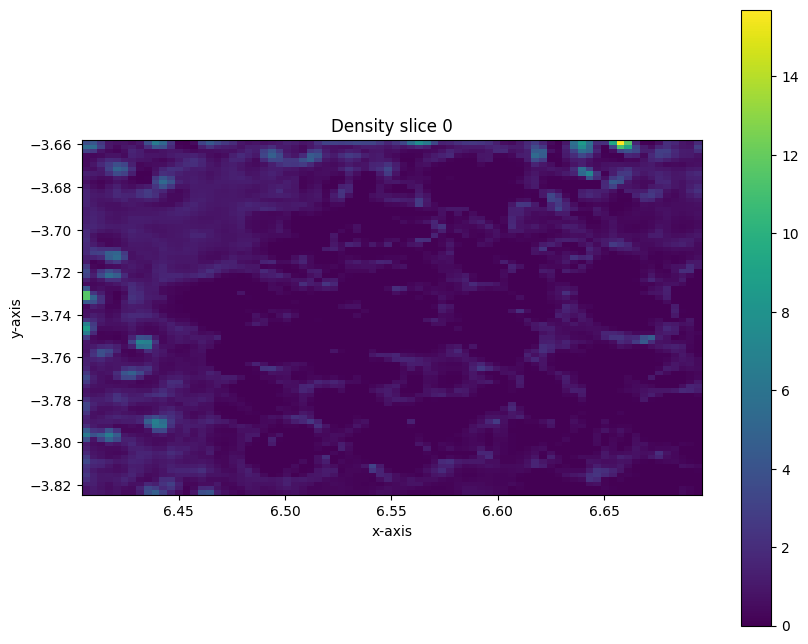

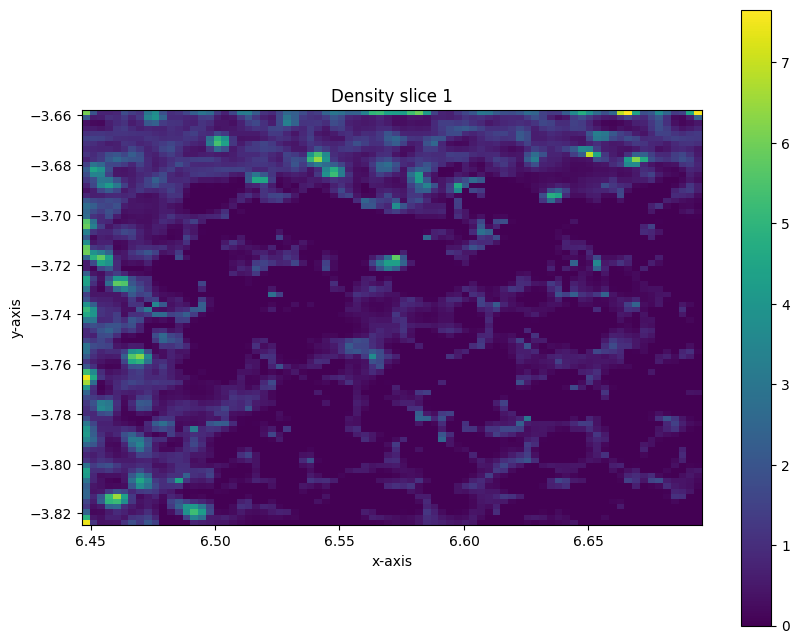

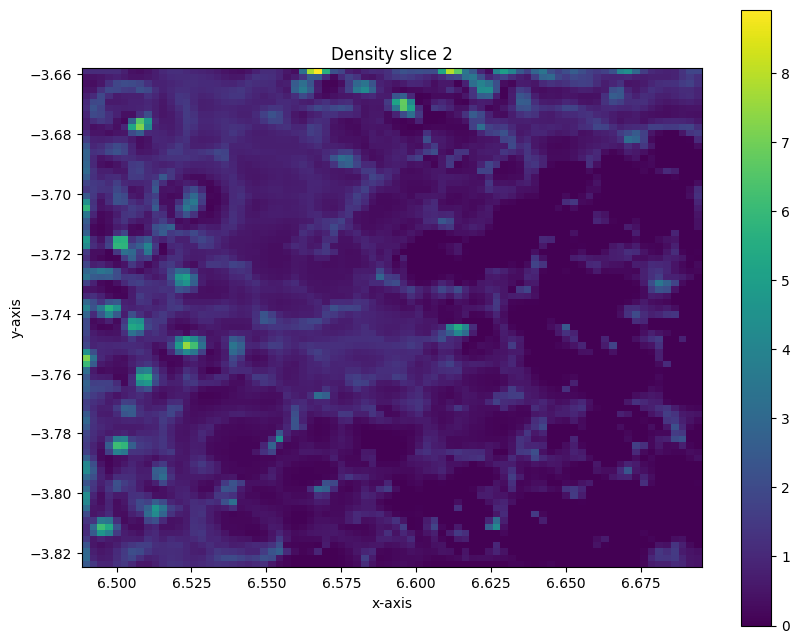

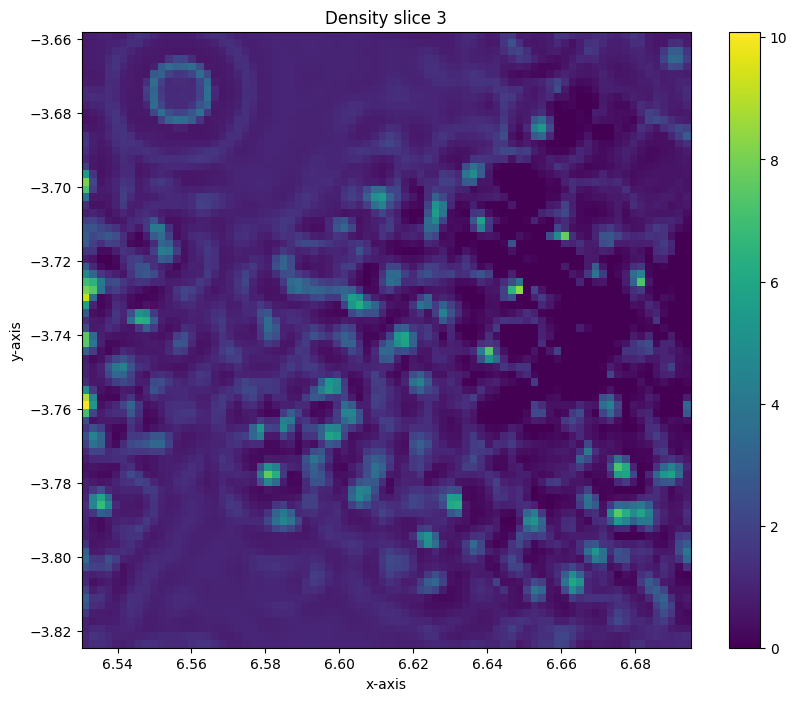

In [12]:
for c, canvas in enumerate(canvases):
    canvas.draw(title=f"Density slice {c}")

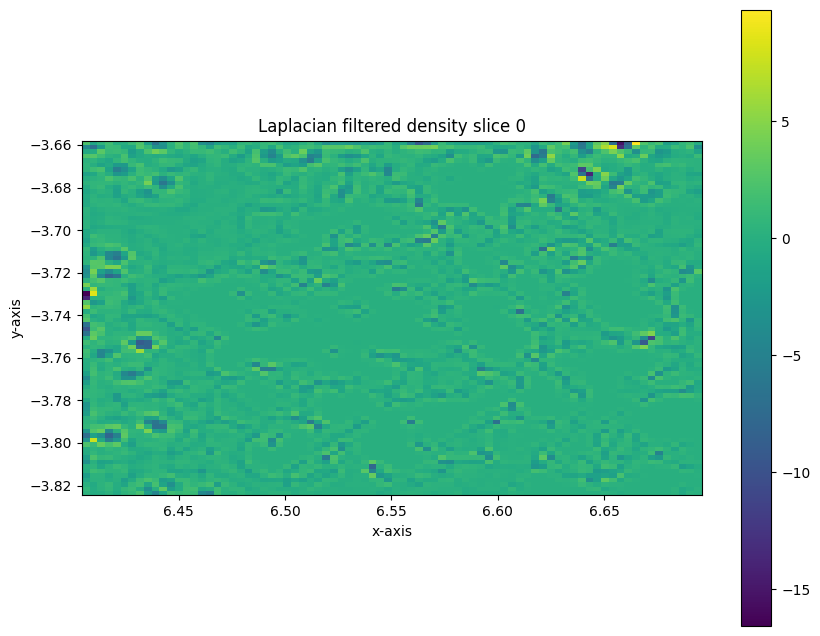

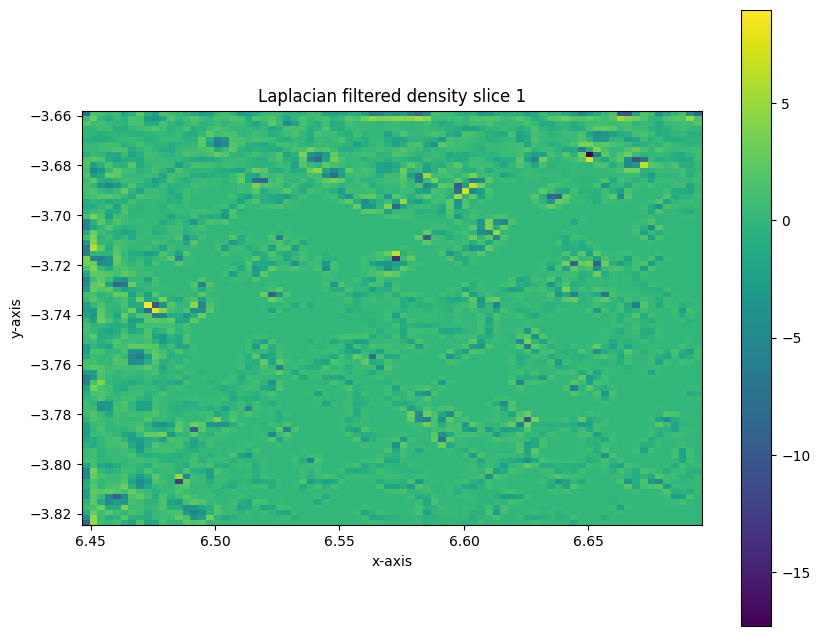

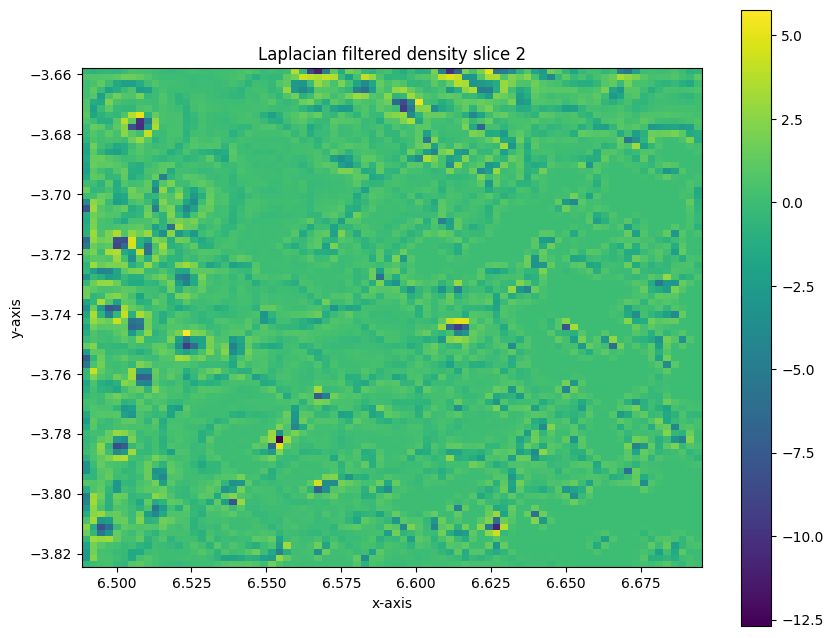

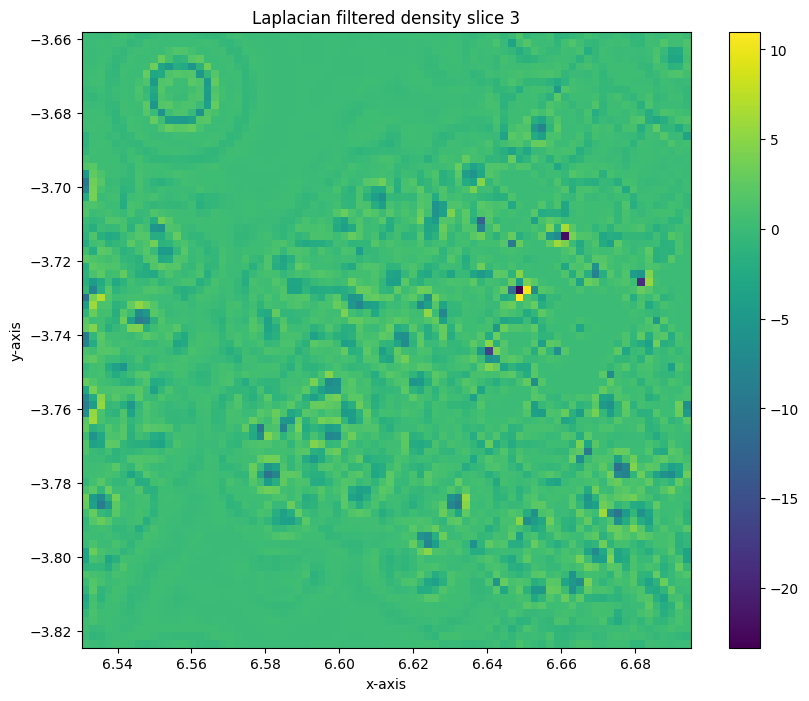

In [13]:
for c, canvas in enumerate(canvases):
    filtered = deepcopy(canvas)
    filtered.filter_density(filter_settings={"filter_function": ndi.laplace})
    filtered.draw(title=f"Laplacian filtered density slice {c}")

In [14]:
og = density_origin(grid)
slicing_planes = [(og + np.array([5, 10, 8]), np.array([0, 1, 1])), (og + np.array([15, 16, 20]), np.array([0, 1, 1])), (og + np.array([25, 22, 32]), np.array([0, 1, 1]))]
canvases_1nnc = density_slices_by_plane(grid, slicing_planes)

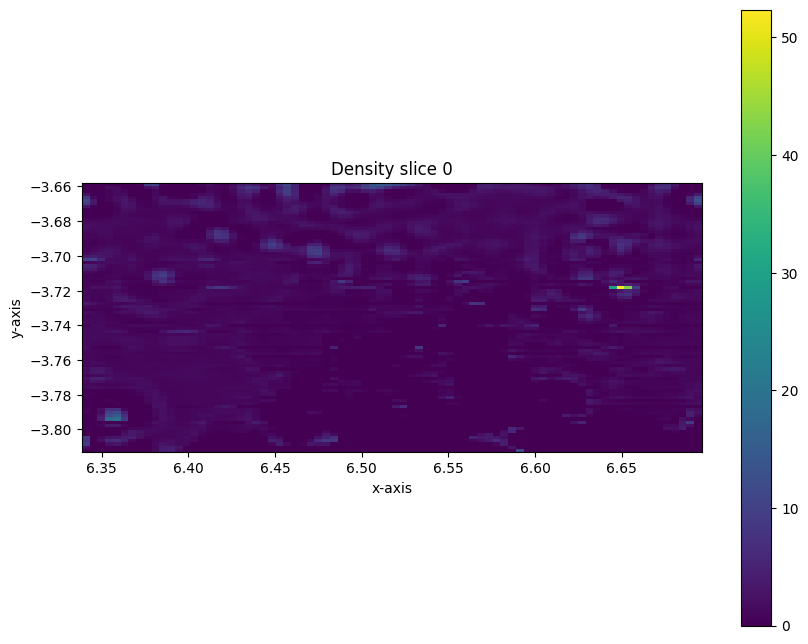

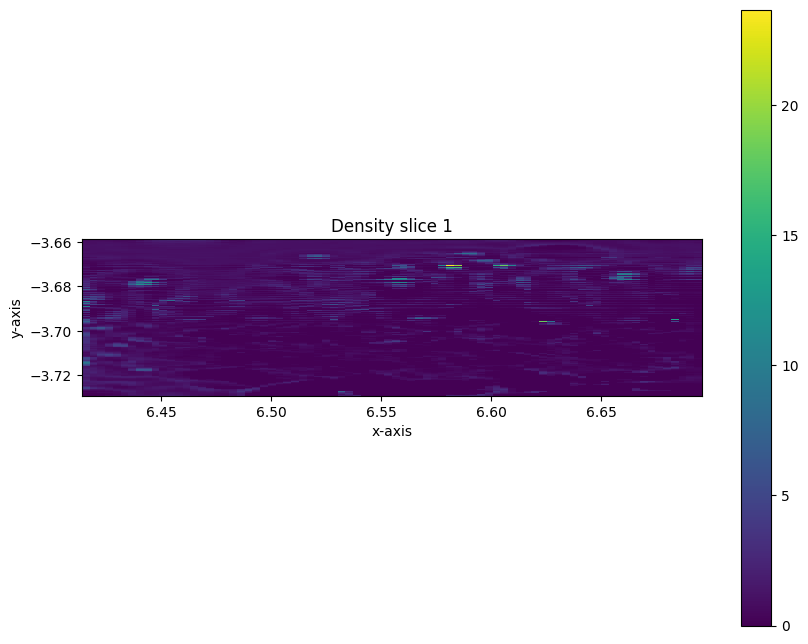

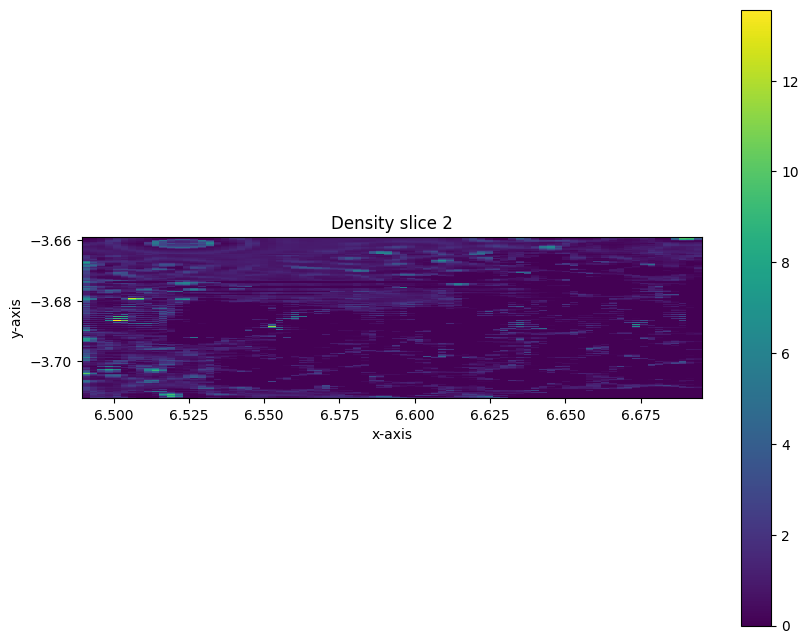

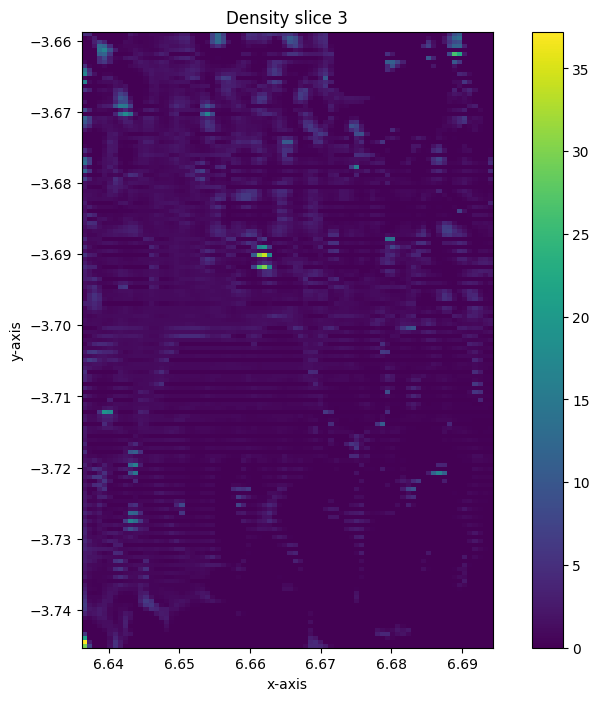

In [15]:
for c, canvas in enumerate(canvases_1nnc):
    canvas.plotting_objects(title=f"Density slice {c}")

In [16]:
canvases_1nnc[0].lattice_rotation

array([[ 0.85355339, -0.        ,  0.        ],
       [ 0.        ,  0.70710678,  0.5       ],
       [-0.        , -0.5       ,  0.70710678]])

In [17]:
cropped_canvases_1nnc = []
x_ranges = [canvases_1nnc[2]._centers[20, 20, 1], canvases_1nnc[2]._centers[60, 20, 1]]
y_ranges = [canvases_1nnc[2]._centers[20, 20, 0], canvases_1nnc[2]._centers[20, 60, 0]]
for c in canvases_1nnc:
    cropped = deepcopy(c)
    cropped.crop_canvas(x_ranges, y_ranges)
    cropped_canvases_1nnc.append(cropped)

In [18]:
from itertools import product

In [19]:
indexes = []
a = np.zeros_like(canvases_1nnc[0]._density)
for x, y in list(product(x_ranges, y_ranges))[:-1]:
    for k, m in np.ndindex(canvases_1nnc[0]._density.shape):
        a[k, m] = np.linalg.norm(canvases_1nnc[0]._centers[k, m, :-1] - (x, y))
    indexes.append(np.unravel_index(np.argmin(a, axis=None), a.shape))
cropped_points = canvases_1nnc[0]._centers[
    indexes[0][0] : indexes[2][0], indexes[0][1] : indexes[1][1], :
]
cropped_density = canvases_1nnc[0]._centers[
    indexes[0][0] : indexes[2][0], indexes[0][1] : indexes[1][1]
]

In [ ]:
cropped_canvases_1nnc[0]._density

In [ ]:
for c, canvas in enumerate(cropped_canvases_1nnc):
    canvas.draw(title=f"Density slice {c}")

In [22]:
grid_bd = density_file_to_grid("../data/3D-RISM_densities/bromoD/prot_3drism.O.1.dx")

In [23]:
print(density_origin(grid_bd))
print(density_point_boundaries(grid_bd))

[101.906 -26.182 -20.756]
[141.906  13.818  19.244]


In [24]:
canvases_bd = density_slices_by_axis(grid, axis=np.array([0, 1, 0]), distances=np.linspace(5, 35, 7, dtype=int))

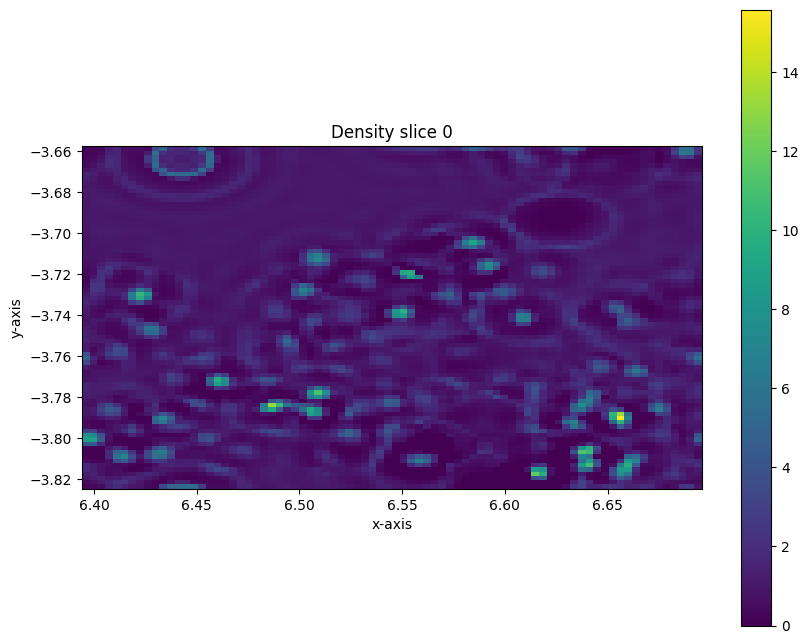

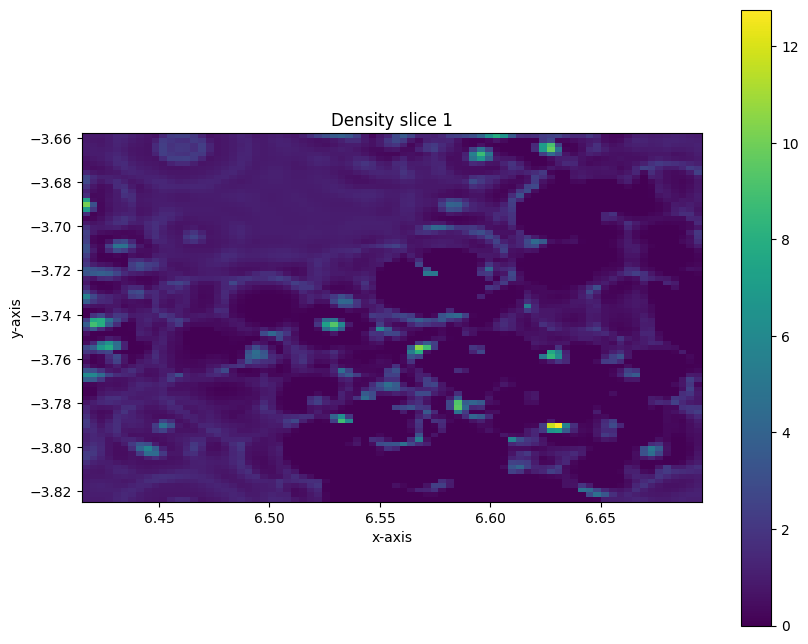

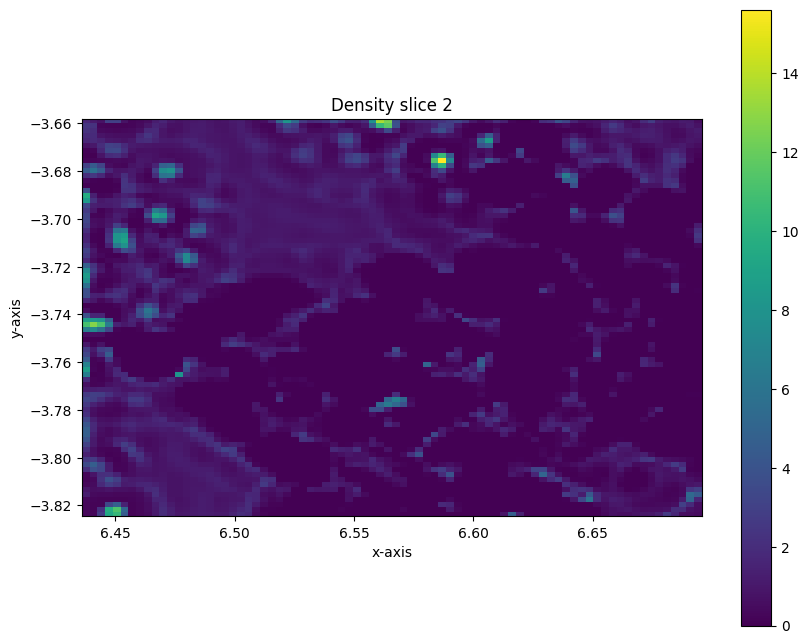

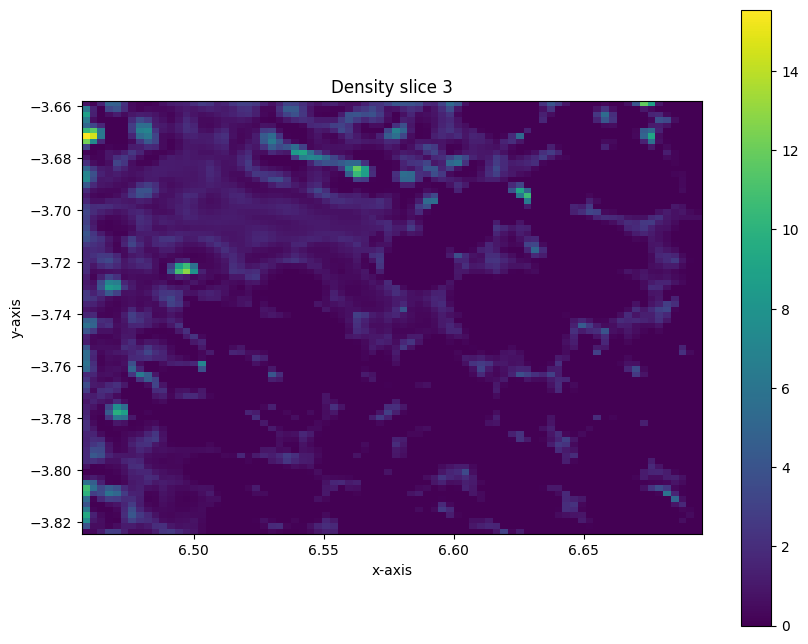

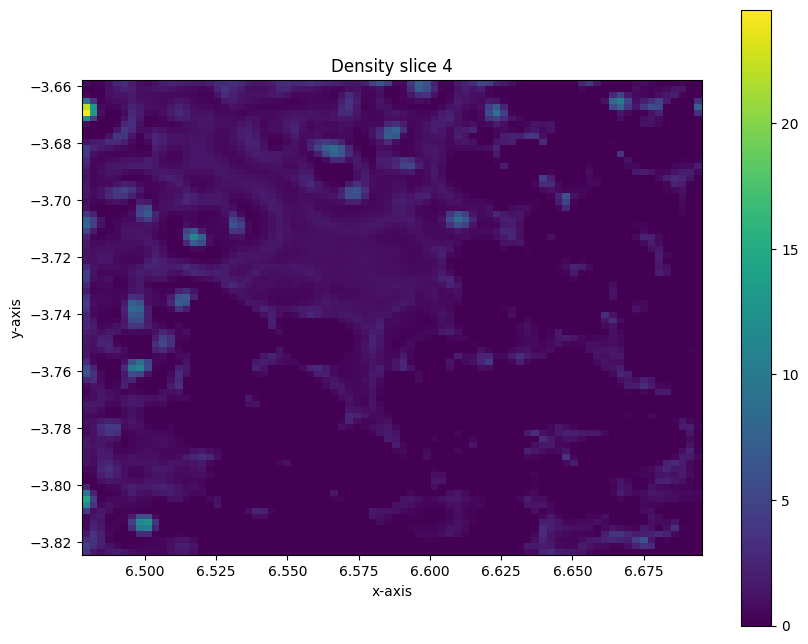

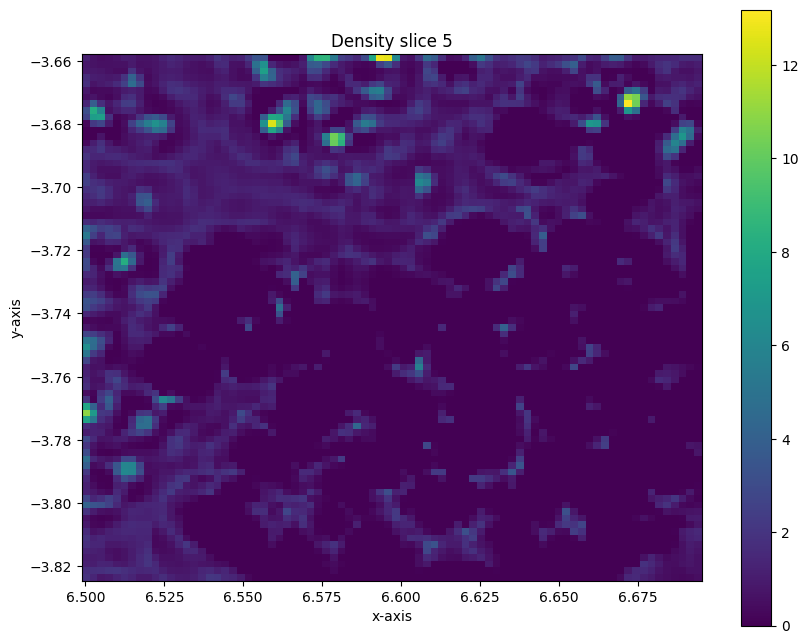

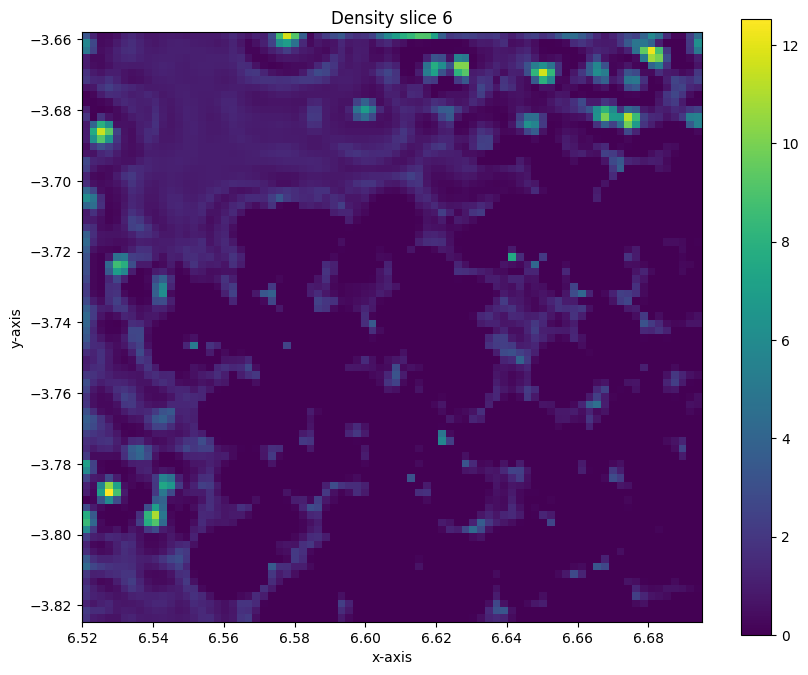

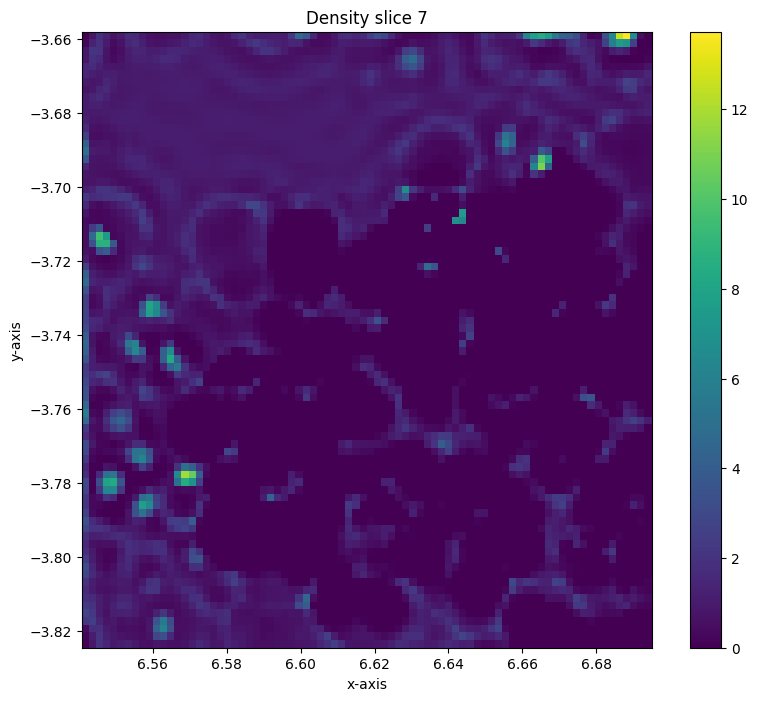

In [25]:
for c, canvas in enumerate(canvases_bd):
    canvas.draw(title=f"Density slice {c}")

In [26]:
grid_dh = density_file_to_grid("../data/3D-RISM_densities/dehydratase/prot_3drism_dT.O.1.dx")

In [27]:
print(density_origin(grid_dh))
print(density_point_boundaries(grid_dh))

[ -9.293  -6.514 -10.821]
[30.707 33.486 29.179]


In [28]:
canvases_dh = density_slices_by_axis(grid, axis=np.array([1, 0, 0]), distances=np.linspace(8, 32, 4, dtype=int))

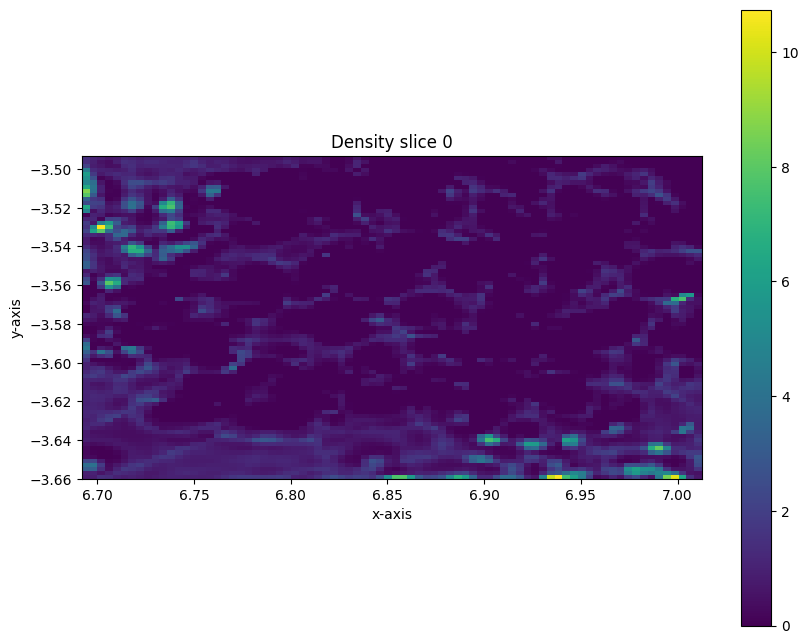

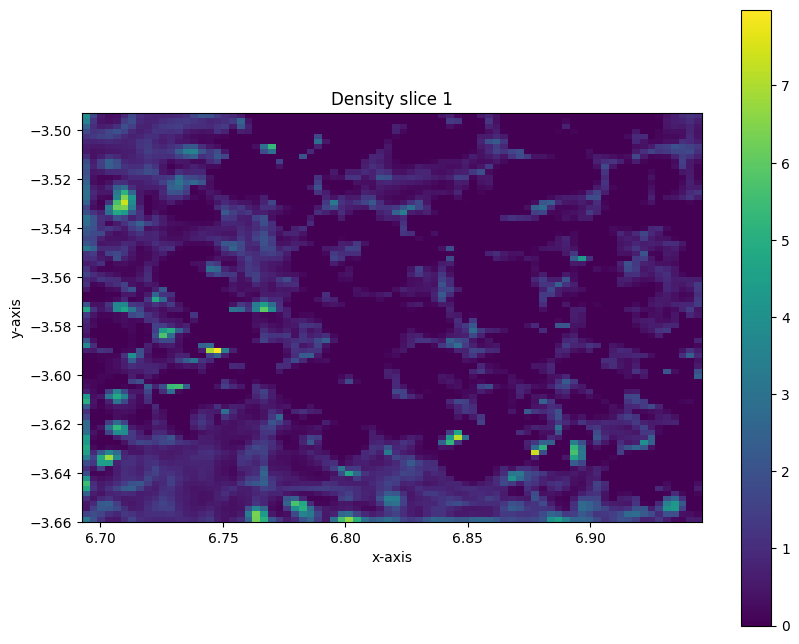

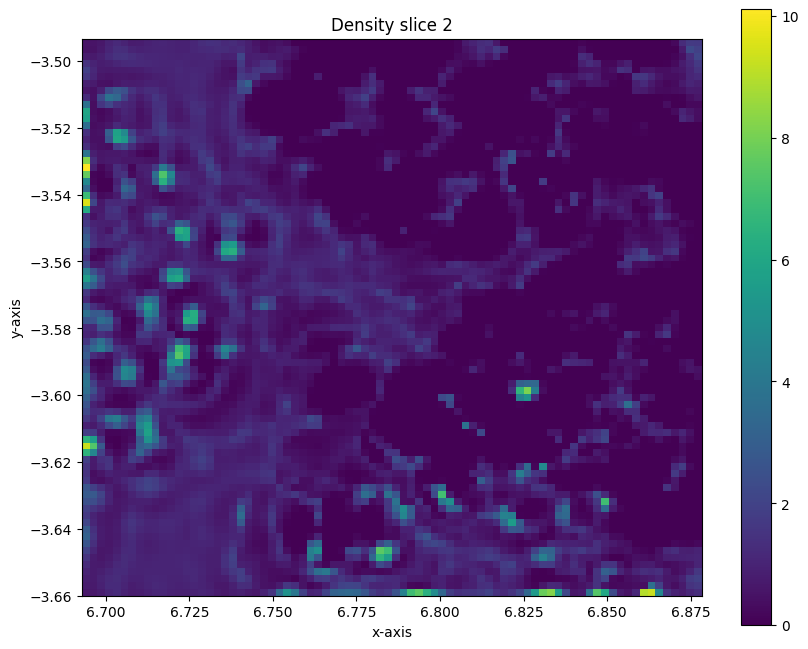

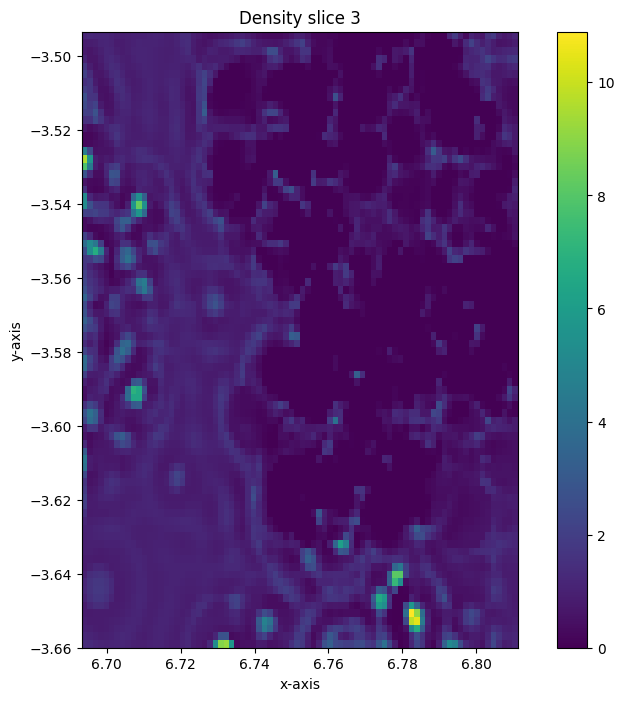

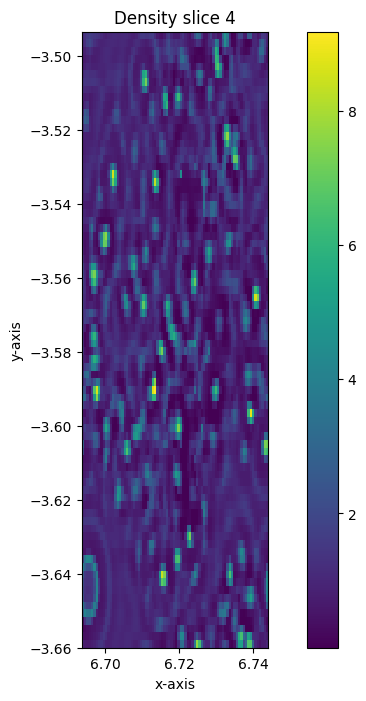

In [29]:
for c, canvas in enumerate(canvases_dh):
    canvas.draw(title=f"Density slice {c}")

In [30]:
# AQUAPOINTING

from pulser import Register
from pulser.devices import MockDevice, AnalogDevice
from pulser_simulation import QutipBackend
import pickle

from aquapointer import water_placement, processor


In [31]:
# import registers
path = "../registers/"
basename = "position_"
positions = []
registers = []
d_list = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5]
for i in range(len(d_list)):
    with open(f'../registers/position_{i}.npy', 'rb') as file_in:
        pos = np.load(file_in)
    positions.append(pos)
    registers.append(Register.from_coordinates(pos)) # this is to create a Pulser register object

basename = "rescaled_position_"
rescaled_positions = []
for i in range(len(d_list)):
    with open(f'../registers/rescaled_position_{i}.npy', 'rb') as file_in:
        res_pos = np.load(file_in)
    rescaled_positions.append(res_pos)

In [32]:
# choose the maximum detuning allowed
max_det = AnalogDevice.channel_objects[0].max_abs_detuning-1

# choose a blockade radius (in micrometers)
# which in turns defines a Rabi frequency
brad = 7
omega = AnalogDevice.rabi_from_blockade(brad)

# choose a pulse duration
T = 3000

pulse_settings = processor.PulseSettings(brad=brad, omega=omega, pulse_duration=T, max_det=max_det)
processor_configs = [processor.AnalogProcessor(device=MockDevice, pos=pos, pos_id=p, pulse_settings=pulse_settings) for p, pos in enumerate(positions)]

In [33]:
def executor(pulse_seq, num_samples):
    sim = QutipBackend(pulse_seq)
    res = sim.run()
    return res.sample_final_state(num_samples)

In [35]:
# Update once DensityCanvas integration done
test_water_postions = water_placement.find_water_positions([c._density for c in canvases], [c._centers for c in canvases], executor, processor_configs)

In [36]:
print(test_water_postions)

[array([37.694, 20.341, 46.76 ]), array([42.194, 28.341, 56.76 ]), array([18.694, 14.841, 66.76 ]), array([42.194, 28.341, 66.76 ]), array([26.694, 12.341, 76.76 ]), array([17.194,  6.841, 76.76 ]), array([40.694, 25.841, 76.76 ])]
